# Safecast Solarcast device data exploration 
### Saksham Gakhar, DA - DKSF


Metadata for csv files is fairly intuitive -- see `df.info()` below

Use `when_captured` field for the timestamp for a reading not `service_uploaded`. Latter is an upload time.

## Known Issues with data
1. RH (`env_humid`) is has bugs, there are values <0 and >100. Need thresholding over entire dataset
2. Devices have more than one reading per time stamp -- why? Here's the data logging process (From Ray Ozzie at Safecast). Point (F) might explain the issue with using `service_uploaded` field -- but issue persists with `when_captured` field also
    1. the device takes a measurement of N sensors (its air sensors, its Geigers, etc) at time == T1.  It packages the captured time and sensor measure,ents into 1 composite JSON object stamped with T1 as “captured time”.
    2. the device stores this json object in flash memory
    3. the device takes another measurement of its sensors at time T2.
    4. the device stores the JSON object with T2 as captured time in flash memory
    5. eventually, after many such json objects are buffered, a “call” is made on cellular.  This “call” is called a “session”.
    6. all the buffered JSON objects are transferrred to the service in less than a second. As a side effect of this transfer, the server stamps each json object with “service uploaded” time.  So all of these json measurements captured over quite some time will all have this session time.
    7. the service forwards them to Ingest, where they are stored in the database.
    
    **Solution: average the multiple readings for groupings agaings device & `when_captured` time stamp**

In [120]:
import numpy as np 
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from collections import defaultdict
from datetime import datetime
# without mpld3
%matplotlib notebook 

# with mpld3
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

In [131]:
df = pd.read_csv('2020-07-06-DataKind/output-2018-04-01T00_00_00+00_00.csv')

In [132]:
df[0:5]

,service_uploaded,when_captured,device_urn,device_sn,device,loc_lat,loc_lon,env_temp,env_humid,pms_pm01_0,pms_pm02_5,pms_pm10_0,lnd_7318c,lnd_7318u,bat_voltage
0,"Apr 30, 2018 @ 20:23:23.000",2018-04-30T20:23:24Z,safecast:678194983,Solarcast #30030,678194983,46.554,15.635,NaN,NaN,NaN,NaN,NaN,27.0,27,3.876
1,"Apr 30, 2018 @ 20:23:06.000",2018-04-30T20:23:09Z,safecast:678194983,Solarcast #30030,678194983,46.554,15.635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Apr 30, 2018 @ 20:22:49.000",2018-04-30T20:22:45Z,safecast:678194983,Solarcast #30030,678194983,46.554,15.635,NaN,NaN,5,7,7,NaN,NaN,NaN
3,"Apr 30, 2018 @ 20:20:20.000",2018-04-30T20:20:17Z,safecast:2670856639,Solarcast #30014,2670856639,34.452,-119.822,41.067,-19.016,4,4,5,33.0,40,4.007
4,"Apr 30, 2018 @ 20:20:20.000",2018-04-30T19:19:58Z,safecast:2670856639,Solarcast #30014,2670856639,34.452,-119.822,39.481,-15.623,2,2,3,34.0,44,4.004


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60349 entries, 0 to 60348
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   service_uploaded  60349 non-null  object 
 1   when_captured     60349 non-null  object 
 2   device_urn        60349 non-null  object 
 3   device_sn         60349 non-null  object 
 4   device            60349 non-null  int64  
 5   loc_lat           60335 non-null  float64
 6   loc_lon           60335 non-null  float64
 7   env_temp          30489 non-null  float64
 8   env_humid         30489 non-null  float64
 9   pms_pm01_0        32806 non-null  object 
 10  pms_pm02_5        32808 non-null  object 
 11  pms_pm10_0        32811 non-null  object 
 12  lnd_7318c         39120 non-null  float64
 13  lnd_7318u         52475 non-null  object 
 14  bat_voltage       20570 non-null  float64
dtypes: float64(6), int64(1), object(8)
memory usage: 6.9+ MB


In [156]:
temp_df = df.groupby(['device_urn', 'when_captured']).size().to_frame('size').reset_index().sort_values('size', ascending=False)

In [157]:
temp_df

,device_urn,when_captured,size
43195,safecast:4249659165,2018-04-13 10:30:36+00:00,12
42842,safecast:4249659165,2018-04-07 00:44:15+00:00,12
3324,safecast:114699387,2018-04-02 21:20:17+00:00,10
13000,safecast:1660294046,2018-04-08 01:48:19+00:00,9
28840,safecast:3373827677,2018-04-13 14:17:04+00:00,9
...,...,...,...
18842,safecast:2299238163,2018-04-29 10:02:47+00:00,1
18843,safecast:2299238163,2018-04-29 10:12:47+00:00,1
18844,safecast:2299238163,2018-04-29 10:22:47+00:00,1
18845,safecast:2299238163,2018-04-29 10:32:47+00:00,1


Need to change the format of the Time Stamp for all the measurements in the raw data

In [137]:
# df.service_uploaded =  df.service_uploaded.apply(lambda x: datetime.strptime(x, '%b %d, %Y @ %H:%M:%S.%f'))

Add a column for the year

In [138]:
df['year'] = pd.DatetimeIndex(df['when_captured']).year

In [139]:
df.describe()

,device,loc_lat,loc_lon,env_temp,env_humid,lnd_7318c,bat_voltage,year
count,6.034900e+04,60335.000000,60335.000000,30489.000000,30489.000000,39120.000000,20570.000000,60349.0
mean,1.831163e+09,37.560917,-33.808646,19.522244,46.451476,30.160890,3.968544,2018.0
std,1.444457e+09,4.762836,112.578365,11.106165,37.815322,7.803865,0.122727,0.0
min,1.146994e+08,33.402000,-122.347000,-3.324000,-73.938000,2.000000,3.590000,2018.0
25%,4.799112e+08,34.148000,-118.409000,12.279000,20.680000,26.000000,3.894000,2018.0
50%,1.344890e+09,34.483000,-118.094000,15.661000,56.302000,30.000000,3.928000,2018.0
75%,3.373828e+09,42.565000,136.163000,24.232000,76.447000,35.000000,3.999000,2018.0
max,4.267748e+09,52.395000,141.016000,66.849000,114.339000,56.000000,4.204000,2018.0


In [140]:
df.when_captured = pd.to_datetime(df.when_captured)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60349 entries, 0 to 60348
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   service_uploaded  60349 non-null  object             
 1   when_captured     60349 non-null  datetime64[ns, UTC]
 2   device_urn        60349 non-null  object             
 3   device_sn         60349 non-null  object             
 4   device            60349 non-null  int64              
 5   loc_lat           60335 non-null  float64            
 6   loc_lon           60335 non-null  float64            
 7   env_temp          30489 non-null  float64            
 8   env_humid         30489 non-null  float64            
 9   pms_pm01_0        32806 non-null  object             
 10  pms_pm02_5        32808 non-null  object             
 11  pms_pm10_0        32811 non-null  object             
 12  lnd_7318c         39120 non-null  float64            
 13  l

Need to correct for the format of the PM numeric values. 

In [141]:
df['pms_pm01_0'] = df['pms_pm01_0'].str.replace(',', '').astype(float)
df['pms_pm10_0'] = df['pms_pm10_0'].str.replace(',', '').astype(float)
df['pms_pm02_5'] = df['pms_pm02_5'].str.replace(',', '').astype(float)

Check how many devices there are in the dataset

In [142]:
devices = np.unique(df.device_urn.values)
print(len(devices))

30


The Particulate Matter (PM) measurements fall into 3 buckets -- PM2.5 means measurements of concentration of particles of size 2.5 micrometer or less and similarly for PM1.0 and PM10.0. All these 3 are measured by the devices in the dataset

In [143]:
pmVals = {1.0:'pms_pm01_0', 2.5:'pms_pm02_5', 10.0: 'pms_pm10_0'}

Group by device_urn

In [144]:
gf = df.groupby('device_urn')

In [145]:
def plotPMsGrouped(pm):
    """
    Function to plot the time series of PMx.y for all the devices in question
    args:
        pm: integer denoting the int "x.y" in "PMx.y"
    """
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = iter(cm.rainbow(np.linspace(0, 1, len(devices))))
    for device in devices:
        s1  = gf.get_group(device)
        ax.plot(s1['when_captured'].values ,s1[pmVals[pm]],'o-', label='{}'.format(device), color= next(colors))
    
    # Set title and labels for axes
    ax.set(xlabel="Date-Time", ylabel="PM "+str(pm),title = "PM {}".format(pm))
    ax.legend()
    plt.show()

Plot all the PM time series
Note: the PMs are cumulative -- for more location specific insights remember you can subtract PM2.5 from PM10 and see which range of PM sizes are dominant for an area. This frames actionable insights

<IPython.core.display.Javascript object>


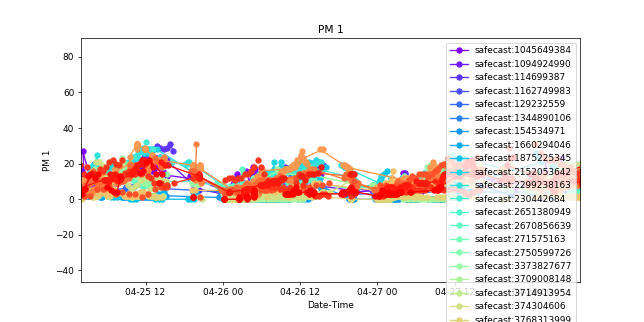

In [146]:
plotPMsGrouped(1)

<IPython.core.display.Javascript object>


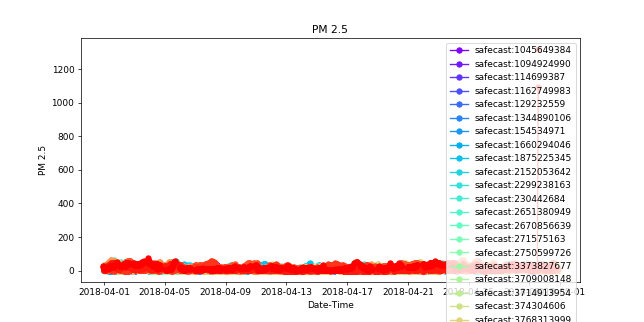

In [147]:
plotPMsGrouped(2.5)

<IPython.core.display.Javascript object>


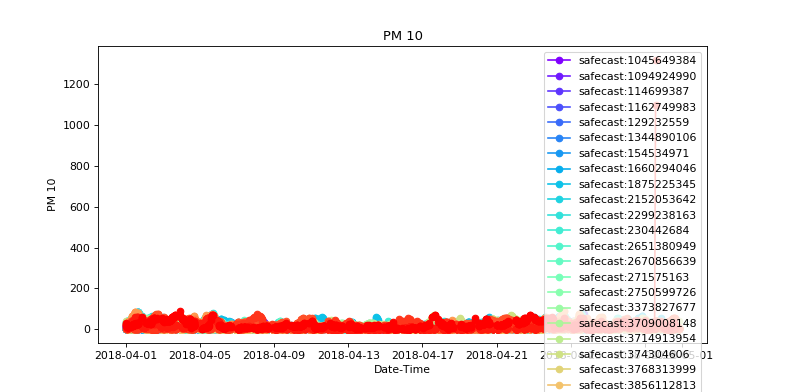

In [58]:
plotPMsGrouped(10)

In [62]:
def plotTimeSeries(ts):
    """
    Function to plot the time series of ts (e.g. 'bat_voltage') for all the devices in question
    args:
        ts: time series column string name "bat_voltage"
    """
    # Create figure and plot space
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = iter(cm.rainbow(np.linspace(0, 1, len(devices))))
    for device in devices:
        s1  = gf.get_group(device)
        ax.plot(s1['when_captured'].values ,s1[ts],'o-', label='{}'.format(device), color= next(colors))
    
    # Set title and labels for axes
    ax.set(xlabel="Date-Time", ylabel=ts ,title = ts)
    ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


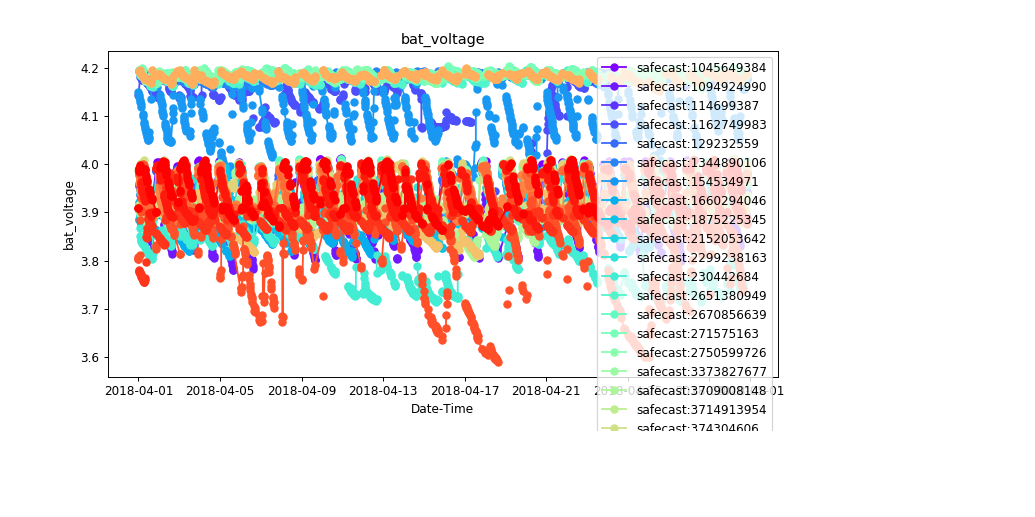

In [63]:
plotTimeSeries('bat_voltage')

<IPython.core.display.Javascript object>


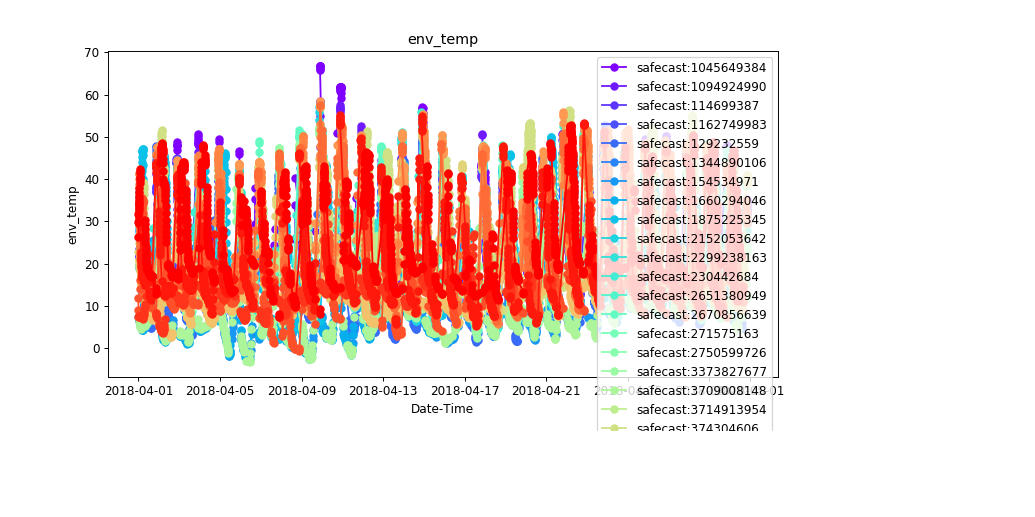

In [74]:
plotTimeSeries('env_temp')

<IPython.core.display.Javascript object>


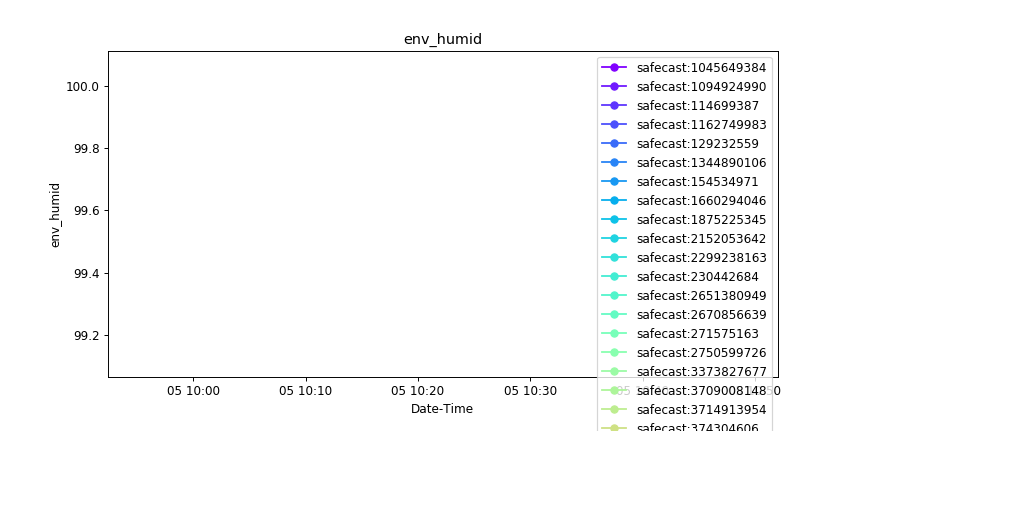

In [75]:
plotTimeSeries('env_humid')

<IPython.core.display.Javascript object>


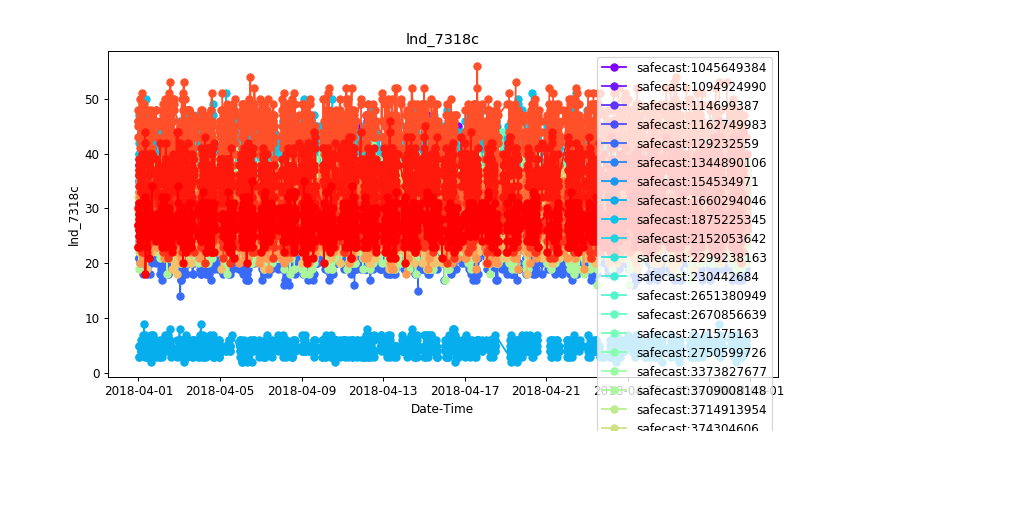

In [77]:
plotTimeSeries('lnd_7318c')